In [ ]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
CRAWL_EMBEDDING_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'

In [ ]:
num_models = 2
lstm_units = 128
dense_hidden_units = 4 * lstm_units
max_len = 220

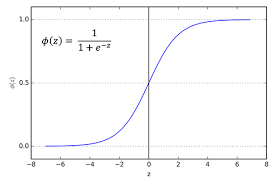![](http://)

#### sigmoid function
- 일정 값을 기준으로 0 인지 1인지 구분하는 함수
- binary classification에 적절한 함수이다.

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

#glove txt 파일 불러오기
def load_embeddings(path):
    # apple 0.3 0.4 0.5 0.6 ...
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))
    
#glove 임베딩 매트릭스 생성
def build_matrix(word_index,path):  #word index -> {a : 1, b : 2, c : 3}
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index)+1, 300)) # 들어온 워드 길이, 임베딩 매트릭스 차원
    unknown_words = [] # 없는 단어 넣기위한 리스트
    
    for word,i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word] # 매트릭스 행에  해당 단어의 인덱스값을 넣는다.
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [ ]:
#sigmoid 함수
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [ ]:
def train_model(model, train,test, loss_fn, output_dim, lr=0.001, batch_size=512,n_epochs=4,
               enable_checkpoint_ensemble=True):
    # 뉴럴넷 모델, 훈련 셋, 테스트 셋, 손실함수, 아웃풋 차원, 러닝레이트, 배치 크기, 반복횟수
    param_lrs = [{'params' : param,' lr' : lr} for param in model.parameters()] # 파이토치 lstm 파라메터 , learing rate 최적화하기 위한 리스트 생성
    optimizer = torch.optim.Adam(param_lrs, lr=lr) # 최적화 함수 / adam optimizer 사용
    
    #learning_rate를 epoch에 따라 변화 가능
    #learning_rate에 람다함수 적용해서 그 결과를 lr로 적용
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch:0.6 ** epoch)
    
    # 학습 및 테스트 데이터에 배치 적용
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size , shuffle=True) # train data 미니배치 적용
    test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size, shuffle=False) # 테스트 데이터 미니배치 적용
    
    all_test_preds = []
    checkpoint_weights = [2**epoch for epoch in range(n_epochs)]
    
    for epoch in range(n_epochs):
        start_time = time.time() # 시작 시간
        
        scheduler.step()
        model.train()# 훈련 모드
        avg_loss = 0. #평균 로스 선언
        
        for data in tqdm(train_loader, disable=False):
            x_batch = data[:-1] # 맨 끝 데이터 제외
            y_batch = data[-1] # 맨 끝 데이터
            
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)#손실 
            
            optimizer.zero_grad()
            loss.backward() #역전파
            
            optimizer.step()
            avg_loss += loss.item() / len(train_loader) #loss.item은 스칼라 값, loss = (1,)의 형태
            
        model.eval() # evalutaion mode로 전환
        test_preds = np.zeros((len(test), output_dim))
        
        for i ,x_batch in enumerate(test_loader):
            y_pred = sigmoid(model(*x_batch).detach().cpu().numpy())
            test_preds[i*batch_size:(i+1)*batch_size, :] = y_pred
            
        all_test_preds.append(test_preds)
        elapsed_time = time.time() - start_time
        print('epoch {}/{} \t loss = {:.4f} \t time={:.2f}s'.format(epoch+1, n_epochs, avg_loss , elapsed_time))
        
    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
        
    return test_preds

In [ ]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K) #특정차원에 1차원 추가 -> 3번째에 1차원을 추가한다.
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K) # 1차원제거
        return x

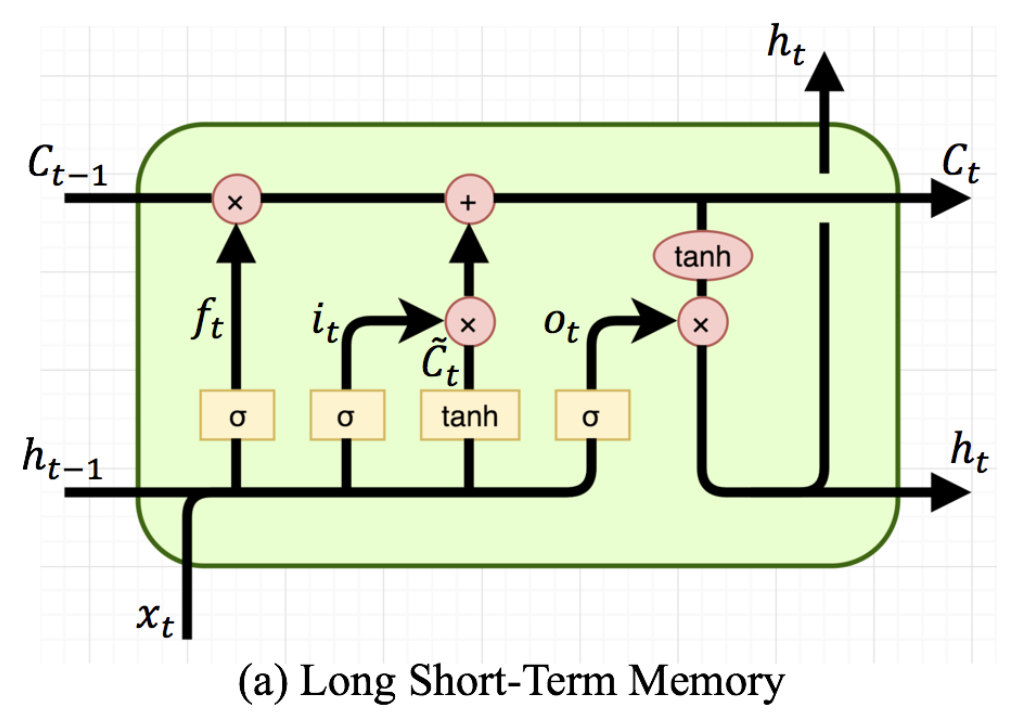

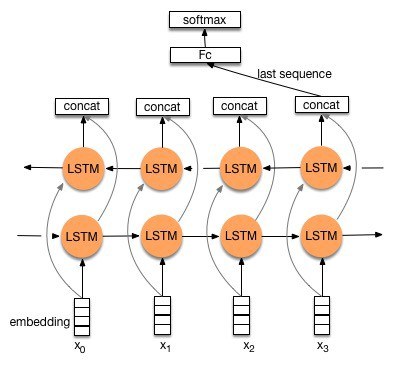

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet,self).__init__()
        embed_size = embedding_matrix.shape[1] #glove 임베딩 매트릭스 행 사이즈
        
        self.embedding = nn.Embedding(max_features, embed_size) #embedding layer 생성 , 임베딩 할 단어 개수, 임베딩 차원)
        #매개변수 자동 등록
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix)) #파라메터
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3) # 드랍아웃 선언
        
        # layer 2층 생성
        self.lstm1 = nn.LSTM(embed_size,lstm_units, bidirectional = True, batch_first=True) # 양방향 lstm
        self.lstm2 = nn.LSTM(lstm_units*2, lstm_units, bidirectional=True, batch_first=True) # 양방향 lstm
        
        # fully connected layer 
        self.linear1 = nn.Linear(dense_hidden_units, dense_hidden_units)
        self.linear2 = nn.Linear(dense_hidden_units, dense_hidden_units)
        
        # 최종 결과 출력 linear layer
        self.linear_out = nn.Linear(dense_hidden_units, 1)
        self.linear_aux_out = nn.Linear(dense_hidden_units, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x) #임베딩 생성
        h_embedding = self.embedding_dropout(h_embedding)#dropout
        
        #lstm n_layers = 2
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [ ]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [ ]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

In [ ]:
train.head()

In [ ]:
x_train = preprocess(train['comment_text'])
y_train = np.where(train['target']>= 0.5,1,0) # 0.5보다 큰 값은 1, 나머지는 0으로

In [ ]:
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = preprocess(test['comment_text'])

In [ ]:
max_features = None

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test)) #단어 기반 인코딩 진행 {word : encoding value}

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train) #각 문자 숫자로 인코딩
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=max_len) #최대 길이로 맞춰주는 것
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

In [ ]:
max_features = max_features or len(tokenizer.word_index) + 1
max_features

In [ ]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

In [ ]:
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

In [ ]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

del crawl_matrix
del glove_matrix
gc.collect()

In [ ]:
x_train_torch = torch.tensor(x_train, dtype=torch.long)
x_test_torch = torch.tensor(x_test, dtype=torch.long)
#hstack - 왼쪽에서 오른쪽으로 붙이기
#np.newaxis 열 추가
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32)

In [ ]:
#텐서 형태의 데이터셋 생성
train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
test_dataset = data.TensorDataset(x_test_torch)

all_test_preds = []

for model_idx in range(num_models):
    print('Model', model_idx)
    seed_everything(1234 + model_idx)
    
    model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
    
    test_preds = train_model(model, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))
    all_test_preds.append(test_preds)
    print()
    


In [ ]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': np.mean(all_test_preds, axis=0)[:, 0]
})

submission.to_csv('submission.csv', index=False)